## TM-TV exercise

0. import resources

In [1]:
import nltk 
import spacy

from collections import defaultdict
#import csv
import ast
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd

import pyLDAvis
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel, LdaModel
from gensim import corpora, similarities, utils
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS

from sklearn.datasets import fetch_20newsgroups

warnings.filterwarnings('ignore') # setting ignore as a parameter

nlp = spacy.load("en_core_web_sm")
stopwords = nltk.corpus.stopwords.words('english')

print("Libraries imported successfully!")

c:\Users\128525\AppData\Local\Programs\Python\Python39\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
c:\Users\128525\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


Libraries imported successfully!


1. Create the corpus -> dictionary with frequency of words for each document and dictionary with tags associated (for further analysis)

1.1 Choose documents

1.2 Pre processing

1.3 Create the dictionary with frequencies 

In [2]:

newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True, remove=('headers', 'footers', 'quotes'))

texts = newsgroups_train.data[:5000]
targets = newsgroups_train.target[:5000]
texts_test = newsgroups_test.data[:100]
targets_test = newsgroups_test.target[:100]
print(list(newsgroups_train.target_names))
# Lets look at some sample news
newsgroups_train.data[:2]

print(len(newsgroups_train.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


In [77]:
path = f'resources/inshort_news_data-5.csv'
path_corpus = f'resources/corpus.txt'
path_target = f'resources/target.txt'
features = []

def load_corpus():
    if not os.path.exists(path_corpus):
        texts = []
        targets = []

        with open(path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            i = 0
            for article in reader:
                if i == 0: 
                    features = article.insert(0, "id")
                    i += 1
                else:
                    text = article[2].replace("\n", " ")
                    texts.append(text)
                    target = article[3]
                    targets.append(target)
                    i += 1
    
        with open (path_corpus, 'w', encoding='utf-8') as f:
            for text in texts:
                f.write('"'+text+'"'+"\n")

        with open (path_target, 'w', encoding='utf-8') as f:
            for target in targets:
                f.write(target+"\n")
    else: 
        
        texts = []
        with open(path_corpus, 'r', encoding='utf-8') as f:
            texts = f.readlines()
            texts = [text.replace('"', '') for text in texts]

        targets = []
        with open(path_target, 'r', encoding='utf-8') as f:
            targets = f.readlines()
    
    return texts, targets

texts, targets = load_corpus()

n_topics = len(list(set(targets)))

print("Number of topics: ", n_topics)

print("Distribution topics: ", dict(pd.Series(targets).value_counts()))

Number of topics:  7
Distribution topics:  {'technology\n': 50, 'sports\n': 50, 'world\n': 50, 'politics\n': 50, 'entertainment\n': 50, 'automobile\n': 50, 'science\n': 50}


2. Create the model 

2.1 Pre processing

2.2 Building Dictionary & Corpus for Topic Model

2.3 Building LDA Topic Model

In [3]:
# Tokenization

def texts_to_tokens(texts: list): 
     texts_token = []
     texts = [text.replace("\n", " ") for text in texts]
     docs = list(nlp.pipe(texts, disable=['ner']))
     for doc in docs:
          #text.replace("\n", " ")
          #text_tokens = nlp(text)
          text_tokens = [token.lemma_ for token in doc if len(token.text) > 2 and not token.is_stop and \
                not token.is_punct and token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]
          text_tokens = list(set(text_tokens))
          texts_token.append(text_tokens)

     return texts_token

def add_bigrams(texts_token: list):
     bigram = Phrases(texts_token, min_count=5, threshold=100, connector_words=ENGLISH_CONNECTOR_WORDS)
     for idx in range(len(texts_token)):
          for token in bigram[texts_token[idx]]:
               if '_' in token and token not in texts_token[idx]:
                    texts_token[idx].append(token)

     return texts_token

#processed_docs = []

#for doc in newsgroups_train.data:
#    processed_docs.append(preprocess(doc))

texts_token = texts_to_tokens(texts)
print("Tokenization done!")
texts_token = add_bigrams(texts_token)
print("added bigrams!")

Tokenization done!
added bigrams!


In [4]:
'''
Preview 'processed_docs'
'''
print(texts_token[:2])

[['addition', 'sport', 'mail', 'look', 'history', 'call', 'year', 'car', 'engine', 'day', 'late', 'model', 'separate', 'spec', 'funky', '70', 'door', 'rest', 'bumper', 'wonder', 'info', 'know', 'early', 'tellme', 'small', 'body', 'see', 'production', 'enlighten'], ['summarize', 'experience', 'floppy', 'rate', 'knowledge', 'network', 'send', 'hour', 'sink', 'brave', 'base', 'request', 'day', 'brief', 'add', 'upgrade', 'message', 'functionality', 'clock', 'procedure', 'card', 'oscillator', 'poll', 'heat', 'usage', 'attain', 'fair', 'answer', 'soul', 'number', 'thank', 'share', 'adapter', 'especially', 'disk', 'detail', 'speed']]


In [5]:
dictionary = corpora.Dictionary(texts_token)

dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [6]:
corpus = [dictionary.doc2bow(text) for text in texts_token]

lda_model = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary, random_state=100)
lda_model.show_topics()

[(0,
  '0.004*"mean" + 0.004*"reason" + 0.004*"give" + 0.004*"feel" + 0.004*"number" + 0.004*"long" + 0.004*"ask" + 0.003*"play" + 0.003*"sure" + 0.003*"great"'),
 (1,
  '0.005*"take" + 0.004*"see" + 0.004*"read" + 0.004*"believe" + 0.003*"bad" + 0.003*"fact" + 0.003*"long" + 0.003*"live" + 0.003*"question" + 0.003*"little"'),
 (2,
  '0.007*"lot" + 0.006*"see" + 0.005*"hear" + 0.005*"like" + 0.005*"game" + 0.004*"day" + 0.004*"team" + 0.004*"well" + 0.004*"play" + 0.004*"great"'),
 (3,
  '0.005*"case" + 0.005*"government" + 0.004*"law" + 0.004*"mean" + 0.004*"state" + 0.004*"question" + 0.004*"start" + 0.004*"force" + 0.003*"include" + 0.003*"let"'),
 (4,
  '0.007*"drive" + 0.007*"system" + 0.005*"game" + 0.005*"buy" + 0.005*"like" + 0.005*"let" + 0.005*"sell" + 0.004*"run" + 0.004*"post" + 0.004*"help"'),
 (5,
  '0.006*"write" + 0.005*"read" + 0.005*"far" + 0.004*"post" + 0.004*"include" + 0.004*"article" + 0.004*"mean" + 0.004*"like" + 0.004*"believe" + 0.004*"mention"'),
 (6,
  '0.0

3. Visualizations of the model 

In [7]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.047355 -0.010302       1        1  19.291372
7     -0.117591  0.030122       2        1  15.904701
0      0.065976 -0.005154       3        1  15.190663
3      0.048993  0.011581       4        1  14.014186
2      0.006345 -0.064345       5        1  11.507501
4     -0.068815 -0.047075       6        1   9.933870
5      0.004053  0.020157       7        1   9.206115
6      0.013684  0.065017       8        1   4.951591, topic_info=           Term        Freq       Total Category  logprob  loglift
163        file  287.000000  287.000000  Default  30.0000  30.0000
576      window  197.000000  197.000000  Default  29.0000  29.0000
876        game  281.000000  281.000000  Default  28.0000  28.0000
177       drive  318.000000  318.000000  Default  27.0000  27.0000
787  government  234.000000  234.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
923        idea   19.309982  293.272741   Topic8  -5.9595   0.2850
95     probably   19.255579  375.308776   Topic8  -5.9623   0.0355
405      happen   18.174645  258.669407   Topic8  -6.0201   0.3499
81         life   17.939890  243.604554   Topic8  -6.0331   0.3969
145    consider   18.190407  307.316980   Topic8  -6.0192   0.1785

[602 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1794      1  0.319212  People
1794      2  0.013300  People
1794      3  0.239409  People
1794      4  0.066502  People
1794      5  0.079803  People
...     ...       ...     ...
226       7  0.129014   wrong
226       8  0.052412   wrong
2160      2  0.869759   xterm
2160      4  0.043488   xterm
2160      6  0.043488   xterm

[2950 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 1, 4, 3, 5, 6, 7])

In [8]:
for i in range(len(texts)):
    print(lda_model[corpus][i])

[(4, 0.6635277), (5, 0.30231476)]
[(4, 0.45290166), (5, 0.36653632), (7, 0.16214477)]
[(2, 0.8048105), (7, 0.18429857)]
[(0, 0.01788284), (1, 0.01787297), (2, 0.017881706), (3, 0.017880712), (4, 0.017899724), (5, 0.017888714), (6, 0.01788414), (7, 0.8748092)]
[(7, 0.95388126)]
[(0, 0.72090584), (5, 0.24903783)]
[(4, 0.9484176)]
[(4, 0.12247091), (5, 0.58041215), (7, 0.27923167)]
[(0, 0.015661962), (1, 0.015649797), (2, 0.015683342), (3, 0.015649624), (4, 0.015683465), (5, 0.015639413), (6, 0.015647292), (7, 0.8903851)]
[(4, 0.8210795), (7, 0.15387478)]
[(2, 0.28753573), (7, 0.6729257)]
[(0, 0.29238406), (1, 0.32514724), (2, 0.13138318), (6, 0.24504972)]
[(0, 0.125), (1, 0.125), (2, 0.125), (3, 0.125), (4, 0.125), (5, 0.125), (6, 0.125), (7, 0.125)]
[(0, 0.06856889), (1, 0.043111365), (2, 0.20762049), (4, 0.12577413), (7, 0.55144507)]
[(2, 0.24886587), (4, 0.31237668), (7, 0.41233647)]
[(0, 0.30893162), (2, 0.6569068)]
[(0, 0.46190688), (7, 0.522751)]
[(2, 0.5888583), (3, 0.32122532), (

4. Evaluation of the model

In [29]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_token, dictionary=dictionary,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.655729426863954


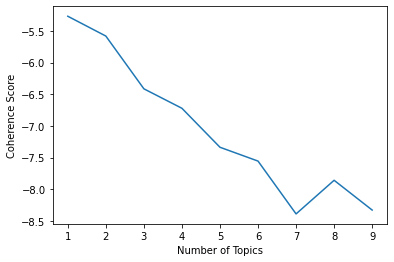

In [82]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

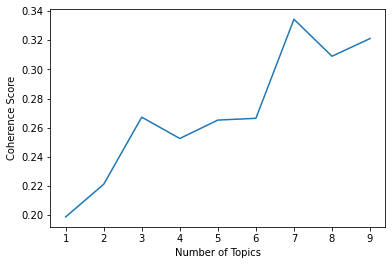

In [83]:
topics = []
score = []
for i in range(1,10,1):
   lda_model_eval = LdaModel(corpus=corpus, id2word=dictionary,num_topics=i, random_state=100)
   cm = CoherenceModel(model=lda_model_eval, texts = texts_token, corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

4. Analysis of the topics using target

In [9]:
topics = [sorted(lda_model[corpus][text])[0][0] for text in range(len(texts))]

topics_df = pd.DataFrame(topics, columns=['topic'])
topics_df['topic'].value_counts().sort_index()

0    2661
1     714
2     487
3     281
4     446
5     152
6      75
7     184
Name: topic, dtype: int64

In [10]:
y_topic = topics_df['topic'].values
lda_topics = lda_model.show_topics(formatted=False)

lda_topics = [[word for word, prob in topic] for topicid, topic in lda_topics]

for text in range(len(texts)): 
    print("Text: ", text)
    print("Result model: ", lda_topics[y_topic[text]])
    print("Real tags: ", targets[text])

Text:  0
Result model:  ['drive', 'system', 'game', 'buy', 'like', 'let', 'sell', 'run', 'post', 'help']
Real tags:  7
Text:  1
Result model:  ['drive', 'system', 'game', 'buy', 'like', 'let', 'sell', 'run', 'post', 'help']
Real tags:  4
Text:  2
Result model:  ['lot', 'see', 'hear', 'like', 'game', 'day', 'team', 'well', 'play', 'great']
Real tags:  4
Text:  3
Result model:  ['mean', 'reason', 'give', 'feel', 'number', 'long', 'ask', 'play', 'sure', 'great']
Real tags:  1
Text:  4
Result model:  ['program', 'file', 'help', 'information', 'mail', 'run', 'line', 'window', 'send', 'set']
Real tags:  14
Text:  5
Result model:  ['mean', 'reason', 'give', 'feel', 'number', 'long', 'ask', 'play', 'sure', 'great']
Real tags:  16
Text:  6
Result model:  ['drive', 'system', 'game', 'buy', 'like', 'let', 'sell', 'run', 'post', 'help']
Real tags:  13
Text:  7
Result model:  ['drive', 'system', 'game', 'buy', 'like', 'let', 'sell', 'run', 'post', 'help']
Real tags:  3
Text:  8
Result model:  ['mea

Unseen documents

In [12]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow((texts_test))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))




Score: 0.125	 Topic: 0.004*"mean" + 0.004*"reason" + 0.004*"give" + 0.004*"feel" + 0.004*"number"
Score: 0.125	 Topic: 0.005*"take" + 0.004*"see" + 0.004*"read" + 0.004*"believe" + 0.003*"bad"
Score: 0.125	 Topic: 0.007*"lot" + 0.006*"see" + 0.005*"hear" + 0.005*"like" + 0.005*"game"
Score: 0.125	 Topic: 0.005*"case" + 0.005*"government" + 0.004*"law" + 0.004*"mean" + 0.004*"state"
Score: 0.125	 Topic: 0.007*"drive" + 0.007*"system" + 0.005*"game" + 0.005*"buy" + 0.005*"like"
Score: 0.125	 Topic: 0.006*"write" + 0.005*"read" + 0.005*"far" + 0.004*"post" + 0.004*"include"
Score: 0.125	 Topic: 0.005*"give" + 0.005*"case" + 0.005*"stuff" + 0.004*"mean" + 0.004*"follow"
Score: 0.125	 Topic: 0.006*"program" + 0.006*"file" + 0.006*"help" + 0.005*"information" + 0.005*"mail"
